# Trabajo Práctico 2: Análisis con Random Forest - Organización de Datos

**Alumnos y Padrón**

    - Enrique, Alvaro Castro - 103991
    - Ivan, Conde - 102497
    - Luizaga, Ricardo - 87528

## Importamos las bibiliotecas necesarias

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import import_ipynb
from FuncionesAux import *

importing Jupyter notebook from FuncionesAux.ipynb


## Importamos los datos y los preprocesamos

**Leemos los datos que tenemos y llamamos a las funciones que se encargarán de dejar listos los datasets.**

In [2]:
train_values,train_labels = obtenerDataTrain()
train_values_subset = prepararDataSet(train_values)
train_values_subset = dummyEncoding(train_values_subset)

# Random Forest

Random forest es un ensamble que consiste en el entrenamiento de varios clasificadores de árbol de decisión. 

Cada árbol del ensamble es construido a partir de una muestra simple con reposición del set de entrenamiento. Además se intenta forzar heterogeneidad entre los árboles al escoger el nodo principal de cada árbol a partir de un subconjunto aleatorio de los features. 

En la implementación de sci-kit learn, cada árbol indica la probabilidad de un feature de pertenecer a una clase. Para la predicción final se promedian estas probabilidades. 

### Random Forest

##### Dividimos el set de datos en sets de training y test

In [3]:
X_train, X_test, y_train, y_test = train_test_split(train_values_subset.values,train_labels.values.ravel())

#### Expandimos el data set:

In [4]:
train_values_subset = expandirDataSet(train_values_subset)

##### Dividimos el set de datos expandido en sets de training y test

In [5]:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(train_values_subset.values,train_labels.values.ravel())

### Buscamos los mejores parámetros

##### Buscamos los mejores parametros para el dataset base

In [ ]:
params = [
    {
        'n_estimators': [150],
        'max_features' : [13],
        'max_depth' : [7],
    },
]

ArbolBase = RandomForestClassifier()
gridBase = GridSearchCV(ArbolBase, params, n_jobs=-1)
gridBase.fit(X_train, y_train)

acc = gridBase.score(X_train, y_train)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(gridBase.best_params_))

##### Buscamos los mejores parametros para el dataset expandido

In [6]:
params = [
    {
        'n_estimators': [150],
        'max_features' : [13],
        'max_depth' : [7],
    },
]

ArbolExp = RandomForestClassifier()
gridExp = GridSearchCV(ArbolExp, params, n_jobs=-1)
gridExp.fit(X_train_exp, y_train_exp)

acc = gridExp.score(X_train_exp, y_train_exp)
print("[INFO] grid search accuracy: {:.2f}%".format(acc * 100))
print("[INFO] grid search best parameters: {}".format(gridExp.best_params_))

[INFO] grid search accuracy: 67.18%
[INFO] grid search best parameters: {'max_depth': 7, 'max_features': 13, 'n_estimators': 150}


### Evaluamos las métricas

##### Utilizando el dataset base

In [ ]:
ArbolBase = RandomForestClassifier(max_depth=gridBase.best_params_["max_depth"],\
                                          max_features=gridBase.best_params_["max_features"],\
                                          n_estimators=gridBase.best_params_["n_estimators"])
ArbolBase.fit(X_train, y_train)
preds = ArbolBase.predict(X_test)
f1_score(y_test, preds, average='micro')

##### Utilizando el dataset expandido

In [7]:
ArbolExp = RandomForestClassifier(max_depth=gridExp.best_params_["max_depth"],\
                                          max_features=gridExp.best_params_["max_features"],\
                                          n_estimators=gridExp.best_params_["n_estimators"])
ArbolExp.fit(X_train_exp, y_train_exp)
preds = ArbolExp.predict(X_test_exp)
f1_score(y_test_exp, preds, average='micro')

0.666405734370923

## Predicciones sobre el nuevo archivo

Obtenemos y preparamos el nuevo archivo realizando el mismo preprocesamiento hecho anteriormente.

Dado que obtuvimos mejores resultados utilizando el dataset expandido y con los parametros encontrados mediante  Gridsearch será este el que utilizaremos para predecir sobre el nuevo archivo.

In [8]:
test_values = obtenerDataTest()
test_values_subset = prepararDataSet(test_values)
test_values_subset = dummyEncoding(test_values_subset)
test_values_subset = expandirDataSet(test_values_subset)

In [9]:
predictions = ArbolExp.predict(test_values_subset)

In [10]:
submission_format = pd.read_csv('submission_format.csv', index_col='building_id')
my_submission = pd.DataFrame(data=predictions,
                             columns=submission_format.columns,
                             index=submission_format.index)
my_submission.to_csv('submission.csv')

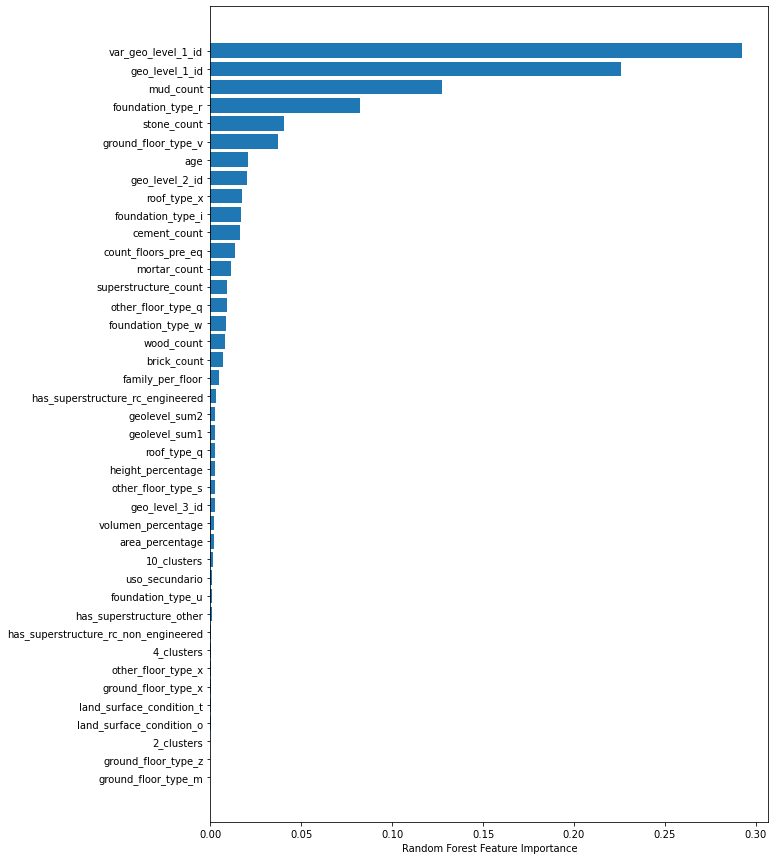

In [24]:
plt.figure(figsize=(10,15))
sorted_idx = ArbolExp.feature_importances_.argsort()
plt.barh(train_values_subset.columns[sorted_idx], ArbolExp.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.savefig("squares.png")